## Import Libraries


In [55]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split


In [56]:

# https://datascience.stackexchange.com/questions/75855/what-types-of-matrix-multiplication-are-used-in-machine-learning-when-are-they
# I wanna be able to stack layers
# idea is if tthis get passed to antoher then it will build the neural net
# build weight matrix
# get frontprop calc to work
from numpy import double


def softmax(x):
    exps = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exps / np.sum(exps, axis=-1, keepdims=True)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0).astype(np.float64)

def sigmoid(x):
    return np.where(
        x >= 0,
        1 / (1 + np.exp(-x)),
        np.exp(x) / (1 + np.exp(x))
    )

def sigmoid_derivative(x):
    sig = sigmoid(x)
    return sig * (1 - sig)

def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def leaky_relu_derivative(x, alpha=0.01):
    dx = np.ones_like(x)
    dx[x < 0] = alpha
    return dx

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - np.tanh(x) ** 2

def binary_cross_entropy(y_pred, y_true, epsilon=1e-12):
    y_pred = np.clip(y_pred, epsilon, 1. - epsilon)
    loss = - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    return np.mean(loss)


def categorical_cross_entropy(y_pred, y_true,  epsilon=1e-8):
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    loss = -np.sum(y_true * np.log(y_pred)) / y_true.shape[0]
    return loss

activation_map = {
    'sigmoid': (sigmoid, sigmoid_derivative),
    'relu': (relu, relu_derivative),
    'tanh': (tanh, tanh_derivative),
    None: (lambda x: x, lambda x: 1)  # No activation
}

class LinearLayer():
    def __init__(self, inFeature, outFeature, activationFunction=None) -> None:
        # self.W=np.random.randint(10, size=(outFeature, inFeature)).astype(np.float64)
        self.W = (np.random.randn(outFeature, inFeature) * np.sqrt(2 / (inFeature + outFeature))).astype(np.float64)
        self.b = np.zeros((1, inFeature), dtype=np.float64)
        self.trainable=True
        self.activation, self.activation_deriv = activation_map.get(
            activationFunction, (lambda x: x, lambda x: 1)
        )
        print(self.activation_deriv)
        self.dEdx=0
        self.dEdy=0
        self.output=0
        self.y=0

    def Forward(self, X):
        self.X = X 
        # print(f"{X.shape}:{self.W.shape}")

        output=X@self.W+self.b
        # print(output)
        self.output=output
        
        if self.activation:
            output = self.activation(output)
        self.y=output
        # print(output)

        return self.output
    
    def Backward(self, y, lr=0.01):
        # okay this is kinda wrong, this is mse dawg
        self.dEdy=self.output-y
        dydx=self.activation_deriv(self.output)
        self.dEdx= dydx*self.dEdy
        # find out how the weight and bias affect the error
        dEdW=self.X.T@self.dEdx
        self.W-=lr*dEdW

        dEdb = np.sum(self.dEdx, axis=0, keepdims=True)
        self.b-=lr*dEdb
        return self.dEdx @ self.W.T   
    def BackwardHidden(self, dEdy, lr=0.01):
        # honestly, dont hardcode it like this, but I got no choice
        dydx=self.activation_deriv(self.output)
        print(f"dEdy value: {dEdy[0]}")
        self.dEdx= dydx*dEdy
        # find out how the weight and bias affect the error
        dEdW=self.X.T@self.dEdx
        self.W-=lr*dEdW
        
        dEdb = np.sum(self.dEdx, axis=0, keepdims=True)
        self.b-=lr*dEdb
        print(f"dEdx value: {self.dEdx[0]} and W value: {self.W.T[0]}")
        return self.dEdx @ self.W.T 
    def Reset(self):
        self.W=0
        self.b=0
        self.output=0
    def FreezeLayer(self):
        self.trainable=False

class Model():
    def __init__(self, layers) -> None:
        self.layers=layers
    def ForwardProp(self, X):
        for i in range(len(self.layers)):
            X=self.layers[i].Forward(X)
        return X
    def BackwardProp(self, dEdy, learningRate=0.01):
        print("running backprop")
        for i, layer in enumerate(self.layers[::-1]):
            dEdy = layer.BackwardHidden(dEdy, lr=learningRate)


def toHotEncoding( classification ):
    # emulates the functionality of tf.keras.utils.to_categorical( y )
    classification = classification.astype(int)  # Ensure integer class labels
    num_samples = classification.shape[0]
    num_classes = np.max(classification) + 1
    hotEncoding = np.zeros((num_samples, num_classes), dtype=np.float32)
    hotEncoding[np.arange(num_samples), classification] = 1
    return hotEncoding

def accuracy(y_pred, y_true):
    # Get predicted class indices
    pred_labels = np.argmax(y_pred, axis=1)
    
    # Convert one-hot to class indices if needed
    if y_true.ndim == 2:
        true_labels = np.argmax(y_true, axis=1)
    else:
        true_labels = y_true

    correct = np.sum(pred_labels == true_labels)
    total = y_true.shape[0]
    return correct / total

def plot_decision_boundary(model, X, y, resolution=0.01):
    # Set min and max values for the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    # Generate a mesh grid
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, resolution),
        np.arange(y_min, y_max, resolution)
    )
    
    # Flatten grid and stack as input
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # Predict using the model
    logits = model.ForwardProp(grid)
    probs = softmax(logits)
    
    predictions = np.argmax(probs, axis=1)
    
    # Reshape to match grid
    zz = predictions.reshape(xx.shape)

    # Plot decision regions
    plt.contourf(xx, yy, zz, alpha=0.5, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=np.argmax(y, axis=1), s=30, edgecolor='k', cmap=plt.cm.coolwarm)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Decision Boundary")
    plt.show()


def visualize_layer_outputs(model, X, y_true, title_prefix=""):
    inputs = X
    if y_true.ndim == 2:
        y_plot = np.argmax(y_true, axis=1)
    else:
        y_plot = y_true

    for i, layer in enumerate(model.layers):
        outputs = layer.Forward(inputs)
        print(outputs.shape)
        if outputs.shape[1] == 2:
            plt.figure()
            plt.scatter(outputs[:, 0], outputs[:, 1], c=y_plot, cmap="viridis", s=10)
            plt.title(f"{title_prefix}Layer {i+1} output")
            plt.xlabel("Feature 1")
            plt.ylabel("Feature 2")
            plt.colorbar()
            plt.grid(True)
            plt.show()
        inputs = outputs  


In [57]:
# RANDOM_SEED = 42
# np.random.seed(RANDOM_SEED)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j


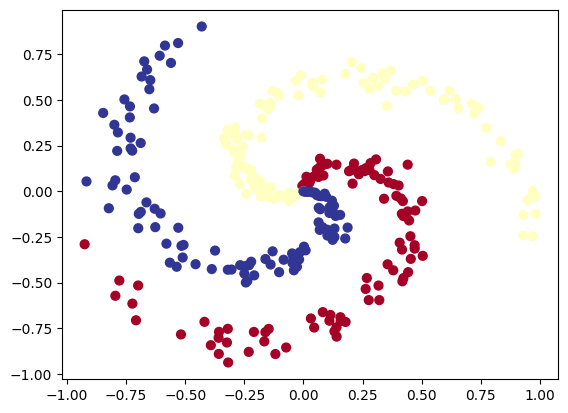

(240, 2) : (240, 3)


In [58]:

plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=42)

y_train=toHotEncoding(y_train)
y_test=toHotEncoding(y_test)
print(f"{X_train.shape} : {y_train.shape}")

<function relu_derivative at 0x7fb215e03060>
<function relu_derivative at 0x7fb215e03060>
<function <lambda> at 0x7fb215fb47c0>


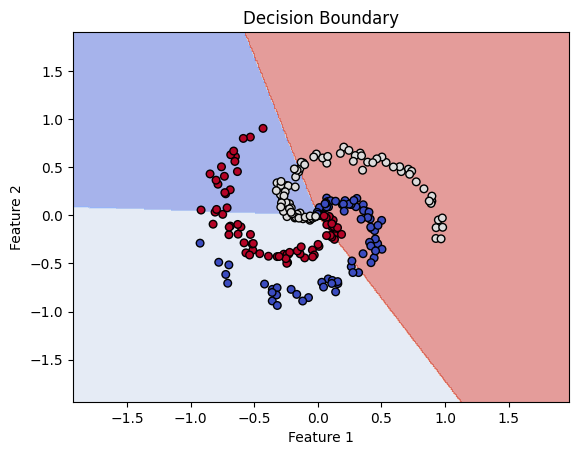

In [59]:

layerSequence=[
LinearLayer(16,2,"relu")
,LinearLayer(16,16,"relu")
# below this is the output layer
,LinearLayer(3, 16)
]

model = Model(layers=layerSequence)

# plot intial prediction
plot_decision_boundary(model, X_train,y_train)

In [ ]:

epochs = 20
losses = [] 

for epoch in range(epochs):
    print(f"Current epoch: {epoch}")
    y_logits = model.ForwardProp(X_train)
    # print(f"{y_pred.shape} : {y_train.shape}")
    y_pred = softmax(y_logits)
    loss = categorical_cross_entropy(y_pred, y_train)
    losses.append(loss)  
    # this is the derivative for cce, since we are using softmax
    gradient=y_pred-y_train
    model.BackwardProp(gradient,learningRate=0.001)
    acc = accuracy(y_pred, y_train)
    print(f"Loss: {loss}, Accuracy: {acc:.2f}")



Current epoch: 0
running backprop
dEdy value: [ 0.33270347  0.35166224 -0.68436571]
dEdx value: [ 0.33270347  0.35166224 -0.68436571] and W value: [-0.02434252 -0.14291131 -0.33672531  0.32335365 -0.35720409 -0.50829673
  0.09208443  0.40957271 -0.21063096  0.24381956  0.51721667  0.22953008
 -0.20493282  0.11904713 -0.29286874  0.11360223]
dEdy value: [ 0.15446891 -0.16911974  0.18494844 -0.13279687  0.05804652 -0.43984871
  0.47681868  0.28663249 -0.14893058 -0.01056196  0.03293686 -0.08827765
 -0.44740164  0.23433285  0.09213024 -0.03497511]
dEdx value: [ 0.         -0.          0.         -0.          0.         -0.43984871
  0.          0.28663249 -0.         -0.01056196  0.03293686 -0.08827765
 -0.44740164  0.23433285  0.09213024 -0.03497511] and W value: [ 0.14809683  0.28010638  0.34792448 -0.38016182 -0.46638541 -0.00941763
 -0.27397397 -0.24747685  0.11687342  0.06677519  0.56388631  0.53104256
 -0.1188957  -0.17940282 -0.11785344 -0.34291912]
dEdy value: [ 0.01046333  0.0857

/tmp/ipykernel_1436003/599118151.py:116: RuntimeWarning: overflow encountered in matmul
  return self.dEdx @ self.W.T
/tmp/ipykernel_1436003/599118151.py:81: RuntimeWarning: overflow encountered in matmul
  output=X@self.W+self.b
/tmp/ipykernel_1436003/599118151.py:10: RuntimeWarning: invalid value encountered in subtract
  exps = np.exp(x - np.max(x, axis=-1, keepdims=True))


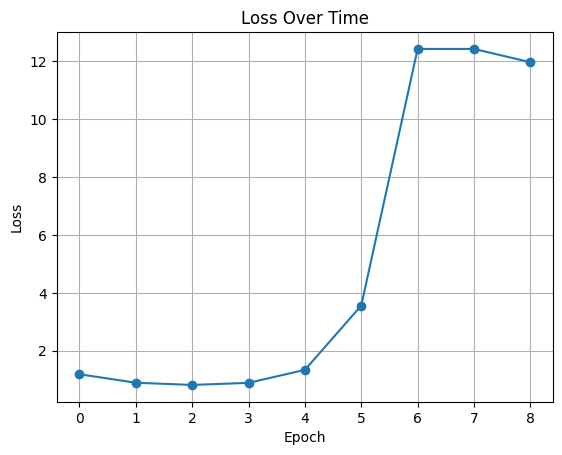

In [61]:

plt.plot(range(epochs), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Time')
plt.grid(True)
plt.show()

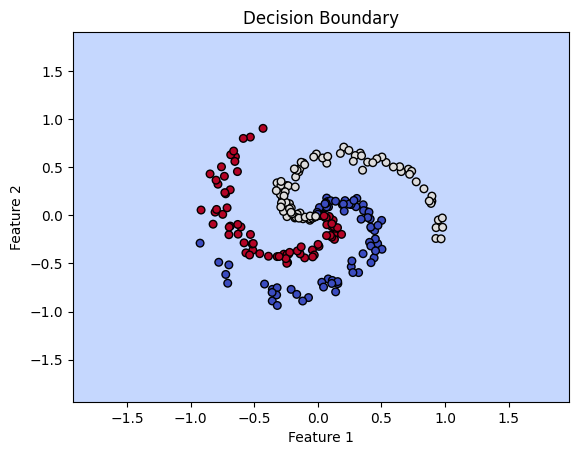

In [62]:
plot_decision_boundary(model, X_train, y_train)

In [63]:
# debugging
# my guess is that the sigmoid got too big of a value, which doesnt make sense
sigmoid(-20000000000000000)

/tmp/ipykernel_1436003/599118151.py:22: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-x)),


array(0.)